In [1]:
library(data.table)
library(ggplot2)
library(qvalue)
library(pheatmap)
library(gridExtra)
library(dplyr)
library(reshape2)
options(stringsAsFactors = FALSE)


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt



In [2]:
#load gcta 
final=fread('/ye/yelabstore3/gracieg/bivarH2/GCTA.std.eqtl.genes.h2.txt')
head(final)

Warning message in fread("/ye/yelabstore3/gracieg/bivarH2/GCTA.std.eqtl.genes.h2.txt"):
“Detected 17 column names but the data has 18 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

V1,gene,cell_pair,sg1,se1,sg2,se2,rg,re,rg_se,Dendritic.cells,CD8.T.cells,FCGR3A..Monocytes,Megakaryocytes,CD4.T.cells,NK.cells,B.cells,CD14..Monocytes
1,A1BG,B.cells_CD14+.Monocytes,0.015170,0.009632,0.028167,0.016146,0.759350,0.041462,0.212675,0,1,1,0,0,0,1,1
2,AAED1,B.cells_CD14+.Monocytes,0.007936,0.010167,0.001736,0.002607,0.786901,0.034356,0.520903,0,0,0,0,1,0,0,0
3,AAGAB,B.cells_CD14+.Monocytes,0.003933,0.004815,0.012858,0.006287,0.773954,0.002871,0.476399,0,0,0,0,0,0,0,1
4,AASDH,B.cells_CD14+.Monocytes,0.000191,0.004039,0.002972,0.003821,-1.000000,0.016548,12.084689,0,0,1,0,0,0,0,1
5,ABAT,B.cells_CD14+.Monocytes,0.010254,0.007361,0.007200,0.006157,0.929170,0.005954,0.382239,0,0,1,0,0,0,0,1
6,ABCA1,B.cells_CD14+.Monocytes,0.013921,0.011571,0.002287,0.009900,1.000000,0.028655,1.786870,0,0,0,0,0,0,1,0


In [3]:
final=final[grep('PBMC', final$cell_pair, invert=T), ]

final$cell_pair=gsub('B.cells', 'B', final$cell_pair)
final$cell_pair=gsub('CD14\\+.Monocytes', 'cM', final$cell_pair)
final$cell_pair=gsub('FCGR3A\\+.Monocytes', 'ncM', final$cell_pair)
final$cell_pair=gsub('CD4.T.cells', 'Th', final$cell_pair)
final$cell_pair=gsub('CD8.T.cells', 'Tc', final$cell_pair)
final$cell_pair=gsub('Megakaryocytes', 'MK', final$cell_pair)
final$cell_pair=gsub('Dendritic.cells', 'cDC', final$cell_pair)
final$cell_pair=gsub('NK.cells', 'NK', final$cell_pair)

final$c1=sapply(strsplit(final$cell_pair, '_'), '[', 1)
final$c2=sapply(strsplit(final$cell_pair, '_'), '[', 2)


table(final$cell_pair)



  B_cDC    B_cM    B_MK   B_ncM    B_NK    B_Tc    B_Th  cDC_MK cDC_ncM  cDC_NK 
   2181    2586    2223    2380    2359    2415    2471    1478    1625    1429 
 cM_cDC   cM_MK  cM_ncM   cM_NK   cM_Tc   cM_Th   MK_NK  ncM_MK  ncM_NK  Tc_cDC 
   2675    2621    2999    2556    2759    2835     884    1353    1250    1947 
  Tc_MK  Tc_ncM   Tc_NK  Th_cDC   Th_MK  Th_ncM   Th_NK   Th_Tc 
   1716    1959    1784    2102    2172    2172    2207    2459 

In [4]:
load_ct_eqtls <- function(ct, dir){
    x=fread(paste(dir, ct, '.bed.ids.txt', sep=''))
    return(list(snps=x, genes=unique(x$gene)))
}

sle=list()

cts=c('B', 'cM', 'ncM', 'Th', 'Tc', 'cDC', 'MK', 'NK')
for(ct in cts){
    print(ct)
    sle[[ct]]=load_ct_eqtls(ct, '/ye/yelabstore3/10x.lupus/eqtls/sle.10pcs.subtracted/all/')
}


[1] "B"
[1] "cM"
[1] "ncM"
[1] "Th"
[1] "Tc"
[1] "cDC"
[1] "MK"
[1] "NK"


[1] "B"

 cDC   cM   MK  ncM   NK   Tc   Th 
2181 2586 2223 2380 2359 2415 2471 
[1] "cM"

   B  cDC   MK  ncM   NK   Tc   Th 
4966 4300 2621 5602 2556 4718 5007 
[1] "ncM"

   B  cDC   cM   MK   NK   Tc   Th 
2380 1625 2999 1353 1250 1959 2172 
[1] "Th"

   B  cDC   cM   MK  ncM   NK   Tc 
2471 2102 2835 2172 2172 2207 2459 
[1] "Tc"

   B  cDC   cM   MK  ncM   NK   Th 
2415 1947 2759 1716 1959 1784 2459 
[1] "cDC"

   B   cM   MK  ncM   NK   Tc   Th 
2181 2675 1478 1625 1429 1947 2102 
[1] "MK"

   B  cDC   cM  ncM   NK   Tc   Th 
2223 1478 2621 1353  884 1716 2172 
[1] "NK"

   B  cDC   cM   MK  ncM   Tc   Th 
2359 1429 2556  884 1250 1784 2207 
  ct_qtl genes  ct        rg
1      B   all cDC 0.3457552
2      B   all  cM 0.4115794
3      B   all  MK 0.3117629
4      B   all ncM 0.3363819
5      B   all  NK 0.3765281
6      B   all  Tc 0.4410088


png 
  2

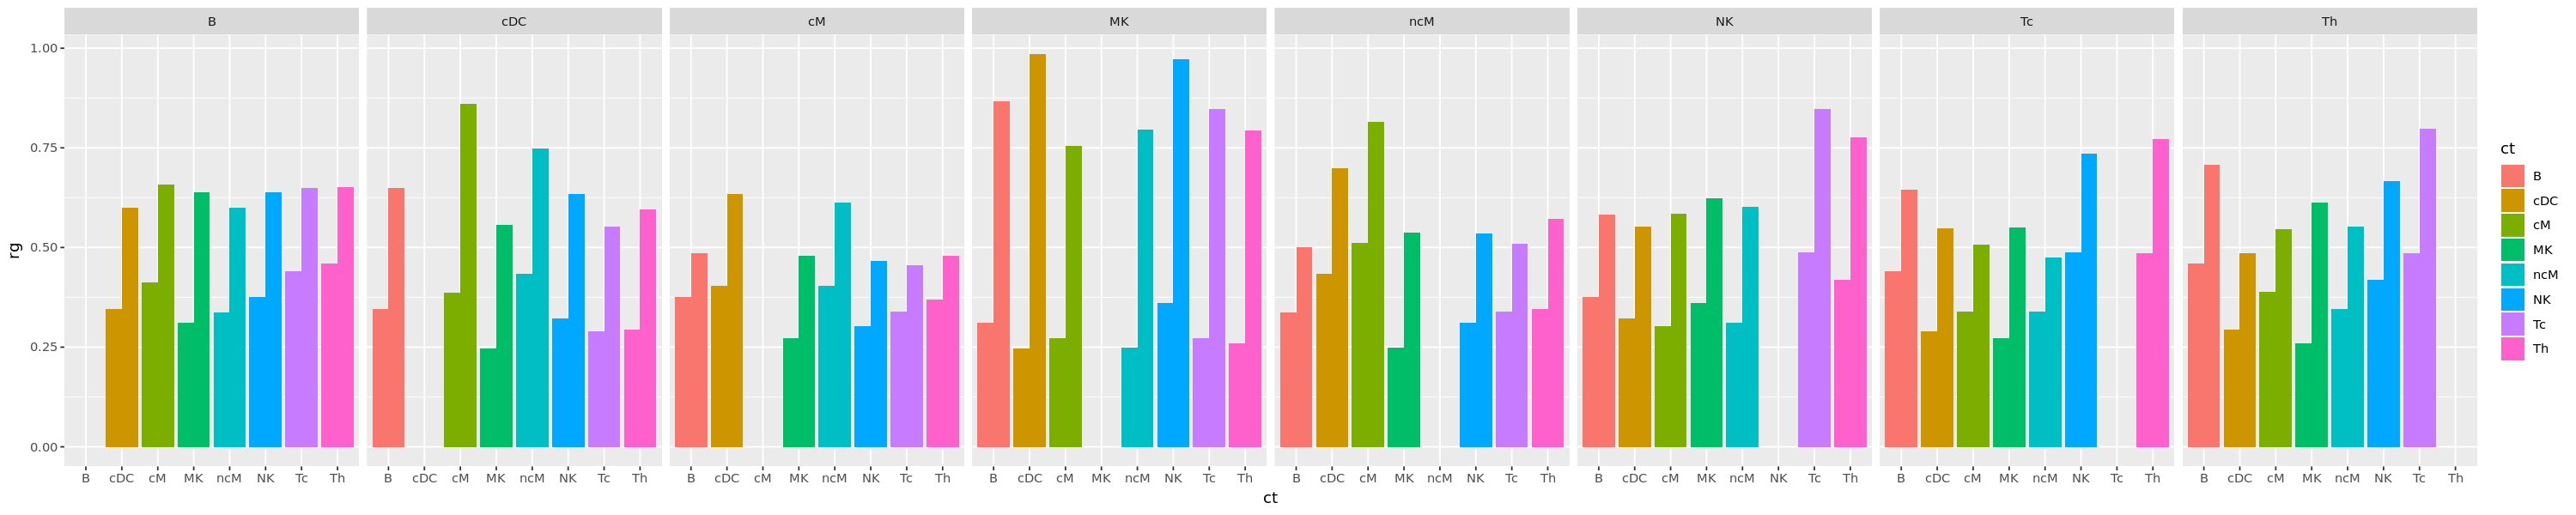

In [9]:
all.df=NULL
for(ct in cts){
    print(ct)
    qtls=sle[[ct]]$genes
    final.use=final[grep(ct, final$cell_pair), ]
    
    final.use$ct=final.use$c1
    final.use$ct[which(final.use$c1==ct)]=final.use$c2[which(final.use$c1==ct)]
    
    print(table(final.use$ct))
    final.use.qtls=final.use[which(final.use$gene %in% qtls), ]
    
    all.genes.mean=aggregate(rg ~ ct, final.use, mean)
    qtls.mean=aggregate(rg ~ ct, final.use.qtls, mean)
    
    all.df=rbind(all.df, data.frame(ct_qtl=ct, genes='all', all.genes.mean))
    all.df=rbind(all.df, data.frame(ct_qtl=ct, genes='CT specific eQTLs', qtls.mean))

    #print(all.genes.mean)
    #print(qtls.mean)
    

}

print(head(all.df))

options(repr.plot.width=25, repr.plot.height=5)

plt=ggplot(all.df, aes(x=ct, y=rg, fill=ct, by=genes))+ geom_bar(stat='identity', position='dodge')  + facet_wrap( ~ ct_qtl, nrow=1 )

print(plt)

pdf('figures/GCTA.eqtls.pdf', width = 25, height=5)
print(plt)
dev.off()
